In [9]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import dicom2nifti
import nibabel as nib
import subprocess
import logging


dicom_folder_path = r"D:\script_di_ale\dicoms"
excel_path = r"D:\script_di_ale\I3LUNG_CT_series_number.xlsx"
tmp_dir_path = r"D:\script_di_ale\temp_dicom"
tmp_out_path = r"D:\script_di_ale\temp_out"

volume, pseudonym = "D:" + os.sep + "script_di_ale", os.sep + "tmp" + os.sep + "script_di_ale"
output_labels = volume + os.sep + "output"
pseudo_volume, pseudonym, pseudo_output_labels = [s.replace("\\","/") for s in (volume, pseudonym, output_labels)]
pseudo_output_labels = pseudo_output_labels.replace(pseudo_volume, pseudonym)

In [10]:
df = pd.read_excel(excel_path)
df.head()

,I3LUNG_ID,CT_series_number,SEG_series_number,segmentation_label
0,INT1010125,5,1017,lung1
1,INT1010735,9,1024,lung1
2,INT1010168,6,1022,lymph1
3,INT1010671,9,1027,lung1
4,INT1010441,7,1021,lymph1


structures are
name(folder)->DICOM(folder)->files
name(folder)->files

BEWARE desktop.ini remove it

In [11]:



def dig(path):
    dcm_path, filenames = [x for x in os.walk(path)][-1][0::2] #walks the dirs until only files are left
    #remove any file ending with .ini in filenames
    filenames = [name for name in filenames if not name.endswith(".ini")]
    return dcm_path, filenames
    

if not os.path.exists(output_labels):
    print("you haven't created the output dir, naughty boy")

if not os.path.exists(os.path.join(output_labels, "imagesTr")):
    print("idiot")
    os.makedirs(os.path.join(output_labels, "imagesTr"))
if not os.path.exists(os.path.join(output_labels, "labelsTr")):
    print("idiot^2")
    os.makedirs(os.path.join(output_labels, "labelsTr"))



cases = sorted(os.listdir(dicom_folder_path))
for case in cases:
    if os.path.exists(os.path.join(output_labels, "imagesTr", f"{case}_0000.nii.gz")):
        print(f"{case} already processed, skipping...")
        continue
    
    a = df[df['I3LUNG_ID'] == case]
    if len(a) == 0:
        print(f"{case} was skipped as it could not be found on df " + " " * 20 + "<-----")
        continue

    CT_series_number = a['CT_series_number'].values[0]
    SEG_series_number = a['SEG_series_number'].values
    print(f"{case} has CT series {CT_series_number} and seg series {SEG_series_number}")

    path, dicom_filenames = dig(os.path.join(dicom_folder_path, case))
    print(f"path is {path}, num of files is {len(dicom_filenames)}")

    #load dicom files
    dicom_files = {}
    for dicom_filename in dicom_filenames:
 
        file_path = os.path.join(path, dicom_filename)
        try:
            dcm = pydicom.dcmread(file_path)
        except:
            raise ValueError(f"Could not open {file_path}")
        
        dicom_files[dicom_filename] = dcm
    CT_filenames = [name for name, dcm in dicom_files.items() if dcm.SeriesNumber == CT_series_number]
    SEG_filenames = [name for name, dcm in dicom_files.items() if dcm.SeriesNumber in SEG_series_number]
    #copy CT files from path
    if not os.path.exists(tmp_dir_path):
        os.makedirs(tmp_dir_path)
    #remove content of tmp folder
    for name in os.listdir(tmp_dir_path):
        os.remove(os.path.join(tmp_dir_path, name))

    #same for tmp_out_path
    if not os.path.exists(tmp_out_path):
        os.makedirs(tmp_out_path)
    #remove content of tmp folder
    for name in os.listdir(tmp_out_path):
        os.remove(os.path.join(tmp_out_path, name))


    #copy CT files from path to tmp each file is os.path.join(path, name) for name in CT_filenames
    for name in CT_filenames:
        shutil.copy2(os.path.join(path, name), os.path.join(tmp_dir_path, name))
    dicom2nifti.convert_directory(tmp_dir_path,tmp_out_path, compression=True, reorient=True)
    #open with nibabel first file in tmp_out
    
    img = nib.load(os.path.join(tmp_out_path, os.listdir(tmp_out_path)[0]))
    #get image data
    img_data = img.get_fdata()
    
    
    img_data[img_data < -1024] = -1024
    #save as  os.path.join(output_labels, case + ".nii.gz") with same affine and header
    img = nib.Nifti1Image(img_data, img.affine, img.header)
    nib.save(img, os.path.join(output_labels, case + "_0000.nii.gz"))
    #.copy2(os.path.join(tmp_out_path, os.listdir(tmp_out_path)[0]), os.path.join(output_labels, case + ".nii.gz"))
    for name in os.listdir(tmp_dir_path):
        os.remove(os.path.join(tmp_dir_path, name))

    for name in os.listdir(tmp_out_path):
        os.remove(os.path.join(tmp_out_path, name))


    seg_data = None
    for n, name in enumerate(SEG_filenames):
        if seg_data is None:
            seg_data = dicom_files[name].pixel_array
        else:
            seg_data += dicom_files[name].pixel_array
    #change so that seg_data is 1 where seg_data > 0
    seg_data = seg_data > 0
    #transpose seg_data, ct is (z,x,y) and seg is (x,y,z)
    print(f"seg_data shape is {seg_data.shape}")
    seg_data = np.transpose(seg_data, (1,2,0))
    #rotate 90 degrees around z axis... yes, I know, it's a bit confusing, but I understand jackshit tbh
    seg_data = np.rot90(seg_data, k=3, axes=(0,1))
        

        
        
        
    print(f"seg_data shape after transpose is {seg_data.shape}")

    #use nibabel to save as nifti with name case_{n}_seg.nii.gz, use img.affine and img.header
    seg_img = nib.Nifti1Image(seg_data, img.affine, img.header)
    nib.save(seg_img, os.path.join(output_labels, case + f"_{n}_seg.nii.gz"))


    print(f"CT_filenames: {len(CT_filenames)}, SEG_filenames: {len(SEG_filenames)}")
    print(f"*" * 30)
    # break # remove this to process all cases, yes I know I'm lazy

        
    

INT1010023 has CT series 16 and seg series [1016]
path is D:\script_di_ale\dicoms\INT1010023\DICOM, num of files is 228
seg_data shape is (226, 512, 512)
seg_data shape after transpose is (512, 512, 226)
CT_filenames: 226, SEG_filenames: 1
******************************


In [12]:
#load with nibabel output/INT1010040
#img = nib.load(os.path.join(output_labels, "INT1010023_0_seg.nii.gz"))
ct, seg = nib.load(os.path.join(output_labels, "INT1010023_0000.nii.gz")), nib.load(os.path.join(output_labels, "INT1010023_0_seg.nii.gz"))
print(ct.shape, seg.shape)

(512, 512, 226) (512, 512, 226)


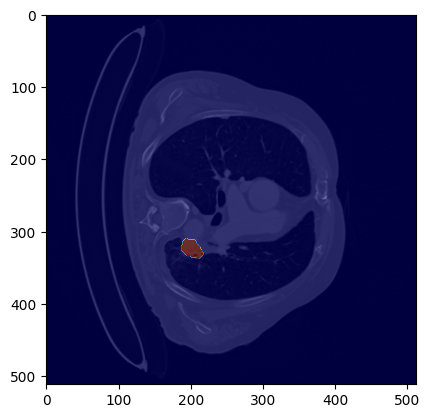

In [13]:
slice_n = 180
plt.imshow(ct.get_fdata()[:,:,slice_n], cmap="gray")
plt.imshow(seg.get_fdata()[:,:,slice_n], cmap="jet", alpha=0.5)

In [14]:
print(ct.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 226   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.92578125  0.92578125  3.          1.          1.
  1.          1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 235.53711
qoffset_y       : -79.03711
qo

In [ ]:
print(seg.header)
